>> Amr Abdelaziz Attia Mohamed 7447

## RNN & Transfer Learning

Some important imports needed in the code 

In [42]:
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
import pickle
from nltk.translate.bleu_score import sentence_bleu
import string
import cv2

Reading the ZIP file of dataset 

In [43]:
# Step 1: Extract the Dataset
with zipfile.ZipFile("archive.zip", "r") as zip_ref:
    zip_ref.extractall("./dataset")

# Paths
dataset_path = "./dataset"
images_path = os.path.join(dataset_path, "images")
captions_path = os.path.join(dataset_path, "captions.txt")


# Loading and Preprocessing Captions

Read the Image ID & Caption and split them by first ','.

The captions are stored in a dictionary with image IDs as keys.

In [44]:
def load_captions(file_path):
    captions = {}
    with open(file_path, "r") as file:
        lines = file.readlines()
    
    # Skip the header line (if it exists)
    for line in lines[1:]:
        if "," not in line:
            continue  # Skip lines without a comma
        image_id, caption = line.strip().split(",", 1)  # Split only at the first comma
        if image_id not in captions:
            captions[image_id] = []
        captions[image_id].append(caption)
    return captions

captions_dict = load_captions(captions_path)


Convert the captions to lowercase and remove punctuations.

Adds special tokens <start> and <end> to each caption.

In [ ]:
def preprocess_captions(captions):
    table = str.maketrans("", "", string.punctuation)
    for key, caps in captions.items():
        for i, cap in enumerate(caps):
            cap = cap.lower().translate(table)
            cap = "<start> " + cap + " <end>"
            captions[key][i] = cap
    return captions

captions_dict = preprocess_captions(captions_dict)


Filters the vocabulary based on a threshold frequency.

keeping only words that appear more than or equal to the given threshold.

In [46]:
def filter_vocabulary(tokenizer, threshold=5):
    word_counts = tokenizer.word_counts
    filtered_vocab = {word: count for word, count in word_counts.items() if count >= threshold}
    tokenizer = Tokenizer(num_words=len(filtered_vocab), oov_token="<unk>")
    tokenizer.fit_on_texts(filtered_vocab.keys())
    return tokenizer

# VGG16 Model for Feature Extraction

Loading the VGG16 

In [47]:
# Step 4: Load VGG16 Model for Feature Extraction
vgg = VGG16(weights="imagenet", include_top=False, pooling="avg")  # Global Average Pooling
model_vgg = Model(inputs=vgg.input, outputs=vgg.output)

# Print VGG16 model summary
model_vgg.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

- Preprocess an image for the VGG16 model.

- Extracts features from the images using the VGG16 model.

- The extracted features are saved to a file using pickle.

In [48]:
# Step 5: Preprocess Images for VGG16
def preprocess_image_vgg(image_path):
    img = Image.open(image_path).resize((224, 224))  # Resize to 224x224 for VGG16
    img = np.array(img)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = preprocess_input(img)  # Apply VGG16-specific preprocessing
    return img


# Step 6: Extract Features Using VGG16
def extract_features_vgg(image_dir):
    features = {}
    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        if img_name.endswith(".jpg"):  # Process only .jpg images
            img = preprocess_image_vgg(img_path)
            features[img_name] = model_vgg.predict(img)
    return features


# Extract features and save them to a file
features_dict = extract_features_vgg(images_path)

with open("vgg_features.pkl", "wb") as f:
    pickle.dump(features_dict, f)

1/1 [==============================] - 0s 102ms/step


# Tokenization and Sequence Creation

A Tokenizer from Keras is initialized to convert captions into sequences of integers.

In [49]:
all_captions = [cap for caps in captions_dict.values() for cap in caps]
tokenizer = Tokenizer(oov_token="<unk>")
tokenizer.fit_on_texts(all_captions)
tokenizer = filter_vocabulary(tokenizer, threshold=5)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1


This function prepares the data for training the model.

It generates image-caption pairs, where each caption is split into a sequence of words.

In [50]:
def create_sequences(captions_dict, tokenizer, max_length=25):
    X_img, X_seq, y = [], [], []
    for img_name, caps in captions_dict.items():
        feature = features_dict[img_name]
        for cap in caps:
            seq = tokenizer.texts_to_sequences([cap])[0]
            for i in range(1, len(seq)):
                X_img.append(feature)
                X_seq.append(seq[:i])
                y.append(seq[i])
    return np.array(X_img), pad_sequences(X_seq, maxlen=max_length), np.array(y)


max_length = 25
X_img, X_seq, y = create_sequences(captions_dict, tokenizer, max_length)



# RNN Model Construction

This function builds the image captioning model. It takes both image features and sequences of words as inputs and outputs the next word in the sequence.

- Image Features: The image features are processed through a Dense layer and dropout.

- Text Sequence: The captions (as sequences of integers) are passed through an Embedding layer and an LSTM layer.

- The model combines these two paths with a tf.keras.layers.Add() and produces the output using a Dense layer with a softmax activation.

- Compilation: The model is compiled using categorical crossentropy loss and the Adam optimizer.

In [52]:
def build_model(vocab_size, max_length, feature_dim=512, embedding_dim=256, lstm_units=256):
    image_input = Input(shape=(feature_dim,), name='image_input')
    fe1 = Dropout(0.2)(image_input)
    fe2 = Dense(embedding_dim, activation='relu')(fe1)

    text_input = Input(shape=(max_length,), name='text_input')
    se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(text_input)
    se2 = Dropout(0.2)(se1)

    lstm_layer = LSTM(
        lstm_units,
        return_sequences=False,
        implementation=2,
        recurrent_activation='sigmoid',
        activation='tanh'
    )
    decoder1 = lstm_layer(se2)
    decoder2 = Dropout(0.2)(decoder1)

    decoder3 = tf.keras.layers.Add()([decoder2, fe2])

    outputs = Dense(vocab_size, activation='softmax')(decoder3)

    model = Model(inputs={'image_input': image_input, 'text_input': text_input}, outputs=outputs)

    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=['accuracy']
    )

    return model

embedding_dim = 256
lstm_units = 256
feature_dim = 512

model = build_model(vocab_size, max_length, feature_dim, embedding_dim, lstm_units)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 25)]                 0         []                            
                                                                                                  
 embedding_4 (Embedding)     (None, 25, 256)              766208    ['text_input[0][0]']          
                                                                                                  
 dropout_13 (Dropout)        (None, 25, 256)              0         ['embedding_4[0][0]']         
                                                                                                  
 image_input (InputLayer)    [(None, 512)]                0         []                            
                                                                                            

Print the shapes of x_img, X_seq and Y

In [53]:
X_img = np.squeeze(X_img)
print("X_img shape:", X_img.shape)  # Should be (num_samples, 2048)
print("X_seq shape:", X_seq.shape)  # Should be (num_samples, max_length)
print("y shape:", y.shape)          # Should be (num_samples,)


X_img shape: (476960, 512)
X_seq shape: (476960, 25)
y shape: (476960,)


Monitors the validation loss during training.

In [55]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# Model Training

The model is trained using the training data (X_img_train, X_seq_train) and validated using the validation set (X_img_val, X_seq_val).

In [56]:
from tensorflow.keras.utils import to_categorical

X_img_train, X_img_val, X_seq_train, X_seq_val, y_train, y_val = train_test_split(
    X_img, X_seq, y, test_size=0.2, random_state=42)

y_train = to_categorical(y_train, num_classes=vocab_size)
y_val = to_categorical(y_val, num_classes=vocab_size)

history = model.fit(
    {'image_input': X_img_train, 'text_input': X_seq_train}, 
    y_train,
    validation_data=({'image_input': X_img_val, 'text_input': X_seq_val}, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop]
)

Epoch 1/100
5962/5962 [==============================] - 583s 97ms/step - loss: 3.5054 - accuracy: 0.3328 - val_loss: 3.0445 - val_accuracy: 0.3733
Epoch 2/100
5962/5962 [==============================] - 617s 104ms/step - loss: 2.9550 - accuracy: 0.3774 - val_loss: 2.9061 - val_accuracy: 0.3869
Epoch 3/100
5962/5962 [==============================] - 613s 103ms/step - loss: 2.7961 - accuracy: 0.3909 - val_loss: 2.8449 - val_accuracy: 0.3955
Epoch 4/100
5962/5962 [==============================] - 622s 104ms/step - loss: 2.6911 - accuracy: 0.4017 - val_loss: 2.8274 - val_accuracy: 0.4003
Epoch 5/100
5962/5962 [==============================] - 614s 103ms/step - loss: 2.6149 - accuracy: 0.4095 - val_loss: 2.8187 - val_accuracy: 0.4023
Epoch 6/100
5962/5962 [==============================] - 623s 105ms/step - loss: 2.5518 - accuracy: 0.4158 - val_loss: 2.8195 - val_accuracy: 0.4051
Epoch 7/100
5962/5962 [==============================] - 634s 106ms/step - loss: 2.4985 - accuracy: 0.4216 

Evaluate the validation set

In [57]:
val_loss, val_accuracy = model.evaluate(
    {'image_input': X_img_val, 'text_input': X_seq_val}, y_val, batch_size=64)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


1491/1491 [==============================] - 42s 28ms/step - loss: 2.8187 - accuracy: 0.4023
Validation Loss: 2.8187, Validation Accuracy: 0.4023


Plotting the Loss curve and Accuracy Curve

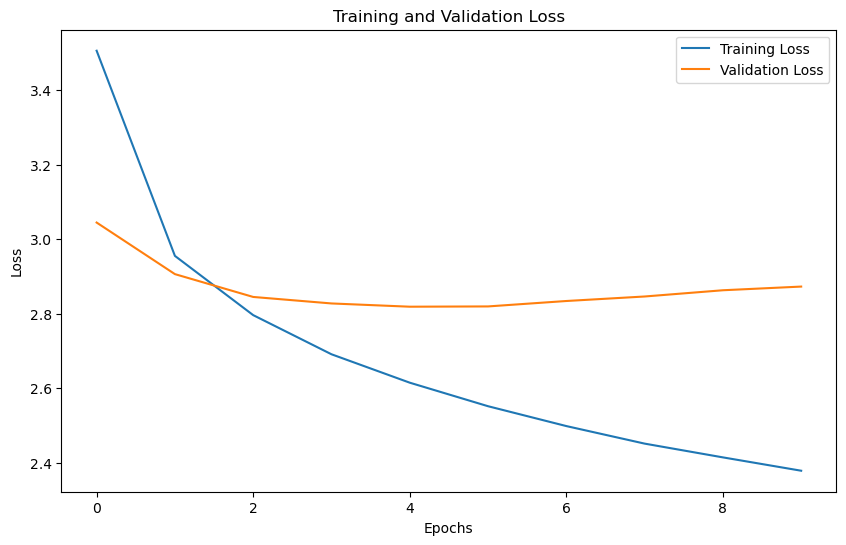

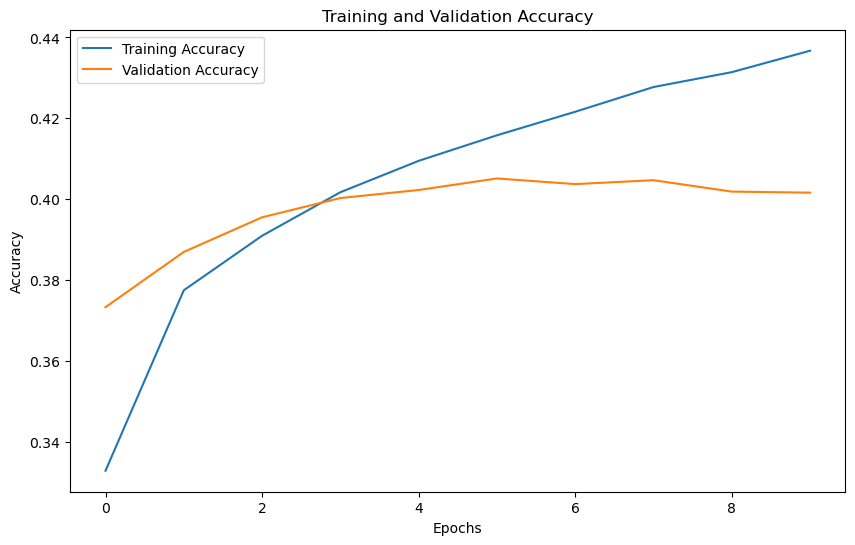

In [58]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Model Evaluation and BLEU Score Calculation

- evaluate_bleu():This function calculates BLEU scores.

- predict_caption():A function to predict a caption for an image using the trained model.

In [61]:
from nltk.translate.bleu_score import corpus_bleu

def evaluate_bleu(model, tokenizer, images, ground_truth_captions, features, max_length, batch_size=32):
    actual, predicted = [], []

    # Preprocess ground truth captions
    for img_name in images:
        actual_captions = ground_truth_captions[img_name]
        actual.append([caption.split() for caption in actual_captions])

    # Process images in batches
    for i in range(0, len(images), batch_size):
        batch_images = images[i:i + batch_size]
        batch_features = [features[img_name] for img_name in batch_images]

        # Generate captions for the batch
        predicted_captions = model_predict_batch(model, batch_features, tokenizer, max_length)

        # Append predicted captions
        predicted.extend(predicted_captions)

    # Compute BLEU scores
    bleu_score_1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))  # BLEU-1
    bleu_score_2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))  # BLEU-2
    print("BLEU-1: %f" % bleu_score_1)
    print("BLEU-2: %f" % bleu_score_2)

    return bleu_score_1, bleu_score_2

def model_predict_batch(model, batch_features, tokenizer, max_length):
    predicted_captions = []
    for image_feature in batch_features:
        predicted_caption = predict_caption(model, image_feature, tokenizer, max_length)
        predicted_captions.append(predicted_caption.split())  # Store as list of words
    return predicted_captions

def predict_caption(model, image_feature, tokenizer, max_length):
    """
    Predict a caption for a given image feature using the trained model.
    """
    # Ensure the feature shape matches the model's input
    image_feature = np.squeeze(image_feature)  # Remove unnecessary dimensions
    
    generated_caption = "<start>"
    for _ in range(max_length):
        # Convert the caption so far into a sequence
        seq = tokenizer.texts_to_sequences([generated_caption])[0]
        seq = pad_sequences([seq], maxlen=max_length)  # Pad the sequence

        # Predict the next word
        pred = model.predict([np.expand_dims(image_feature, axis=0), seq], verbose=0)
        next_word_index = np.argmax(pred)
        next_word = tokenizer.index_word.get(next_word_index, "<unk>")  # Get the word from the index

        # Stop if the end token is generated
        if next_word == "<end>":
            break

        # Append the next word to the caption
        generated_caption += " " + next_word

    # Remove the start and end tokens from the final caption
    return generated_caption.replace("<start>", "").replace("<end>", "").strip()


Example BLEU Evaluation

In [62]:
# Example BLEU evaluation
test_ids = list(captions_dict.keys())[:len(X_img_val)]
bleu_score_1, bleu_score_2 = evaluate_bleu(model, tokenizer, test_ids, captions_dict, features_dict, max_length)


BLEU-1: 0.277039
BLEU-2: 0.169841


# Model Conversion for Deployment

The trained model is converted to TensorFlow Lite format, which is optimized for mobile and edge devices, using TFLiteConverter.

In [64]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # Use TensorFlow Lite built-in operations
    tf.lite.OpsSet.SELECT_TF_OPS     # Allow full TensorFlow operations
]
tflite_model = converter.convert()

with open("model.tflite", "wb") as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\amrka\AppData\Local\Temp\tmp5myh666_\assets


INFO:tensorflow:Assets written to: C:\Users\amrka\AppData\Local\Temp\tmp5myh666_\assets


# Real-Time Video Captioning

- The model is used for real-time image captioning via a webcam feed.

- Frames from the video are captured, processed, and used as input to the trained model to generate captions, which are displayed on the video feed.

In [71]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert OpenCV frame (numpy.ndarray) to a format preprocess_image_vgg can handle
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = Image.fromarray(frame_rgb)  # Convert numpy array to PIL Image

    # Save to a temporary location or use directly (simulate a file path)
    img.save("temp_frame.jpg")
    img_path = "temp_frame.jpg"

    # Use the existing preprocess_image_vgg function
    preprocessed_img = preprocess_image_vgg(img_path)

    # Generate features using VGG16
    feature = model_vgg.predict(preprocessed_img)

    # Generate a caption using the model
    caption = predict_caption(model, feature, tokenizer, max_length)

    # Display the caption on the frame
    cv2.putText(frame, caption, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Show the video frame
    cv2.imshow("Captioning", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 118ms/step


Display images.


In [76]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_png_images(png_path):
    """
    Displays PNG images from a directory or a single PNG file inline.

    Args:
        png_path (str): Path to a directory containing PNG images or a single PNG file.
    """
    if os.path.isdir(png_path):
        # If it's a directory, process all PNG files in the directory
        png_files = [f for f in os.listdir(png_path) if f.endswith(".png")]
        if not png_files:
            print(f"No PNG images found in directory '{png_path}'.")
            return

        for filename in png_files:
            file_path = os.path.join(png_path, filename)
            img = mpimg.imread(file_path)  # Read the image
            plt.figure(figsize=(8, 6))
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"Image: {filename}")
            plt.show()

    elif os.path.isfile(png_path) and png_path.endswith(".png"):
        # If it's a single PNG file, display it
        img = mpimg.imread(png_path)  # Read the image
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Image: {os.path.basename(png_path)}")
        plt.show()
    else:
        print(f"Invalid path: '{png_path}'. Provide a directory or a PNG file.")


Sample 1 from Real_time video captioning

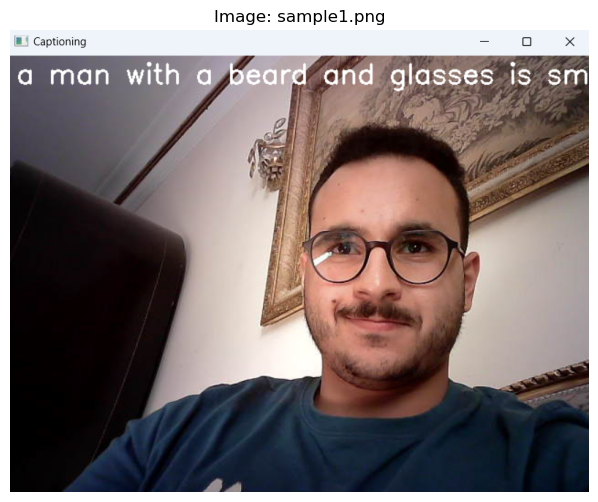

In [77]:
show_png_images("sample1.png")

Sample 2 from Real_time video captioning

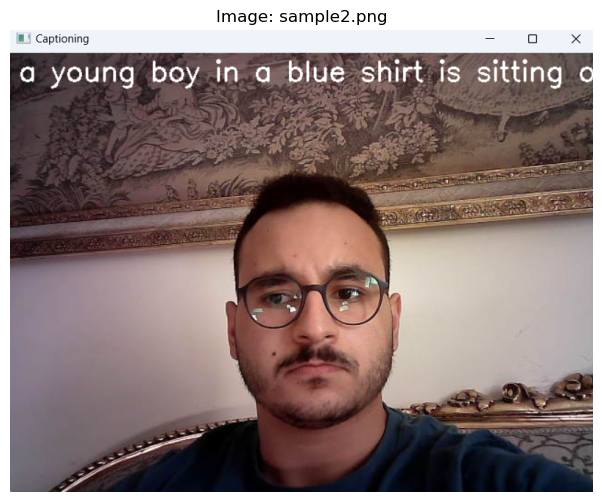

In [78]:
show_png_images("sample2.png")